In [187]:
import pandas as pd
import numpy as np
import datetime
import seaborn as sns
import missingno as msno
import matplotlib.pyplot as plt
import warnings
from datetime import timedelta
import os
%config InlineBackend.figure_format='retina'
warnings.filterwarnings('ignore')

In [22]:
folder_name = '../Inputs/'
file_name = 'dataset_SCL.csv'
df = pd.read_csv(folder_name + file_name)

## Exploratory Data Analysis

In [23]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 68206 entries, 0 to 68205
Data columns (total 18 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   Fecha-I    68206 non-null  object
 1   Vlo-I      68206 non-null  object
 2   Ori-I      68206 non-null  object
 3   Des-I      68206 non-null  object
 4   Emp-I      68206 non-null  object
 5   Fecha-O    68206 non-null  object
 6   Vlo-O      68205 non-null  object
 7   Ori-O      68206 non-null  object
 8   Des-O      68206 non-null  object
 9   Emp-O      68206 non-null  object
 10  DIA        68206 non-null  int64 
 11  MES        68206 non-null  int64 
 12  AÑO        68206 non-null  int64 
 13  DIANOM     68206 non-null  object
 14  TIPOVUELO  68206 non-null  object
 15  OPERA      68206 non-null  object
 16  SIGLAORI   68206 non-null  object
 17  SIGLADES   68206 non-null  object
dtypes: int64(3), object(15)
memory usage: 9.4+ MB


In [24]:
# Convert to datetime
df['Fecha-I'] = pd.to_datetime(df['Fecha-I']) 
df['Fecha-O'] = pd.to_datetime(df['Fecha-O'])

In [25]:
df.dtypes

Fecha-I      datetime64[ns]
Vlo-I                object
Ori-I                object
Des-I                object
Emp-I                object
Fecha-O      datetime64[ns]
Vlo-O                object
Ori-O                object
Des-O                object
Emp-O                object
DIA                   int64
MES                   int64
AÑO                   int64
DIANOM               object
TIPOVUELO            object
OPERA                object
SIGLAORI             object
SIGLADES             object
dtype: object

- Fecha-I: Scheduled date and time of the flight.
- Vlo-I : Scheduled flight number.
- Ori-I : Programmed origin city code.
- Des-I : Programmed destination city code.
- Emp-I : Scheduled flight airline code.
- Fecha-O : Date and time of flight operation.
- Vlo-O : Flight operation number of the flight.
- Ori-O : Operation origin city code
- Des-O : Operation destination city code.
- Emp-O : Airline code of the operated flight.
- DIA: Day of the month of flight operation.
- MES : Number of the month of operation of the flight.
- AÑO : Year of flight operation.
- DIANOM : Day of the week of flight operation.
- TIPOVUELO : Type of flight, I =International, N =National.
- OPERA : Name of the airline that operates.
- SIGLAORI: Name city of origin.
- SIGLADES: Destination city name.

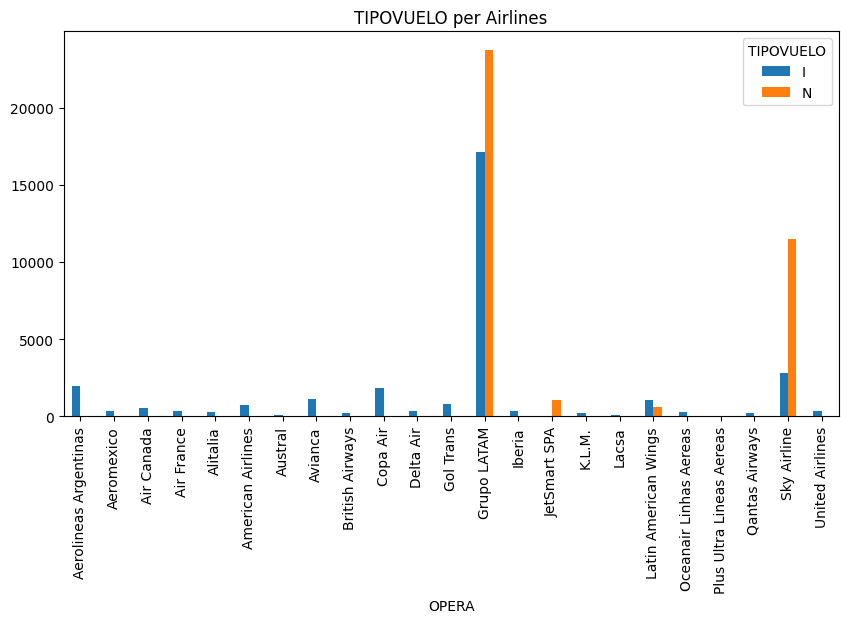

In [26]:
df.groupby(['OPERA','TIPOVUELO']).size().unstack().plot(kind='bar', stacked=False, figsize=(10,5)).set_title('TIPOVUELO per Airlines');

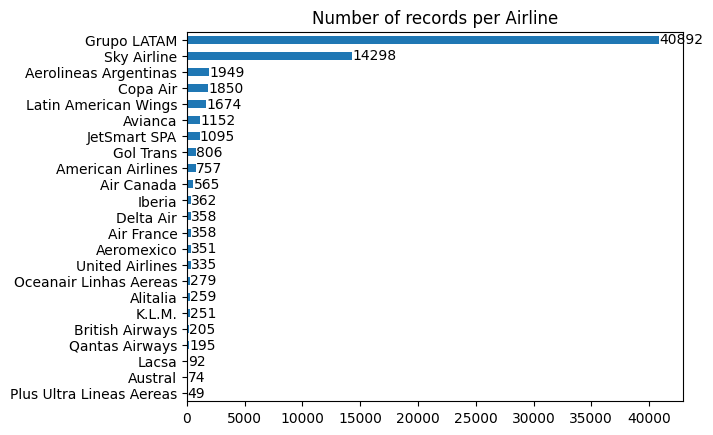

In [27]:
ax = df.OPERA.value_counts(ascending=True).plot.barh()
ax.set_title('Number of records per Airline')
ax.bar_label(ax.containers[0]);

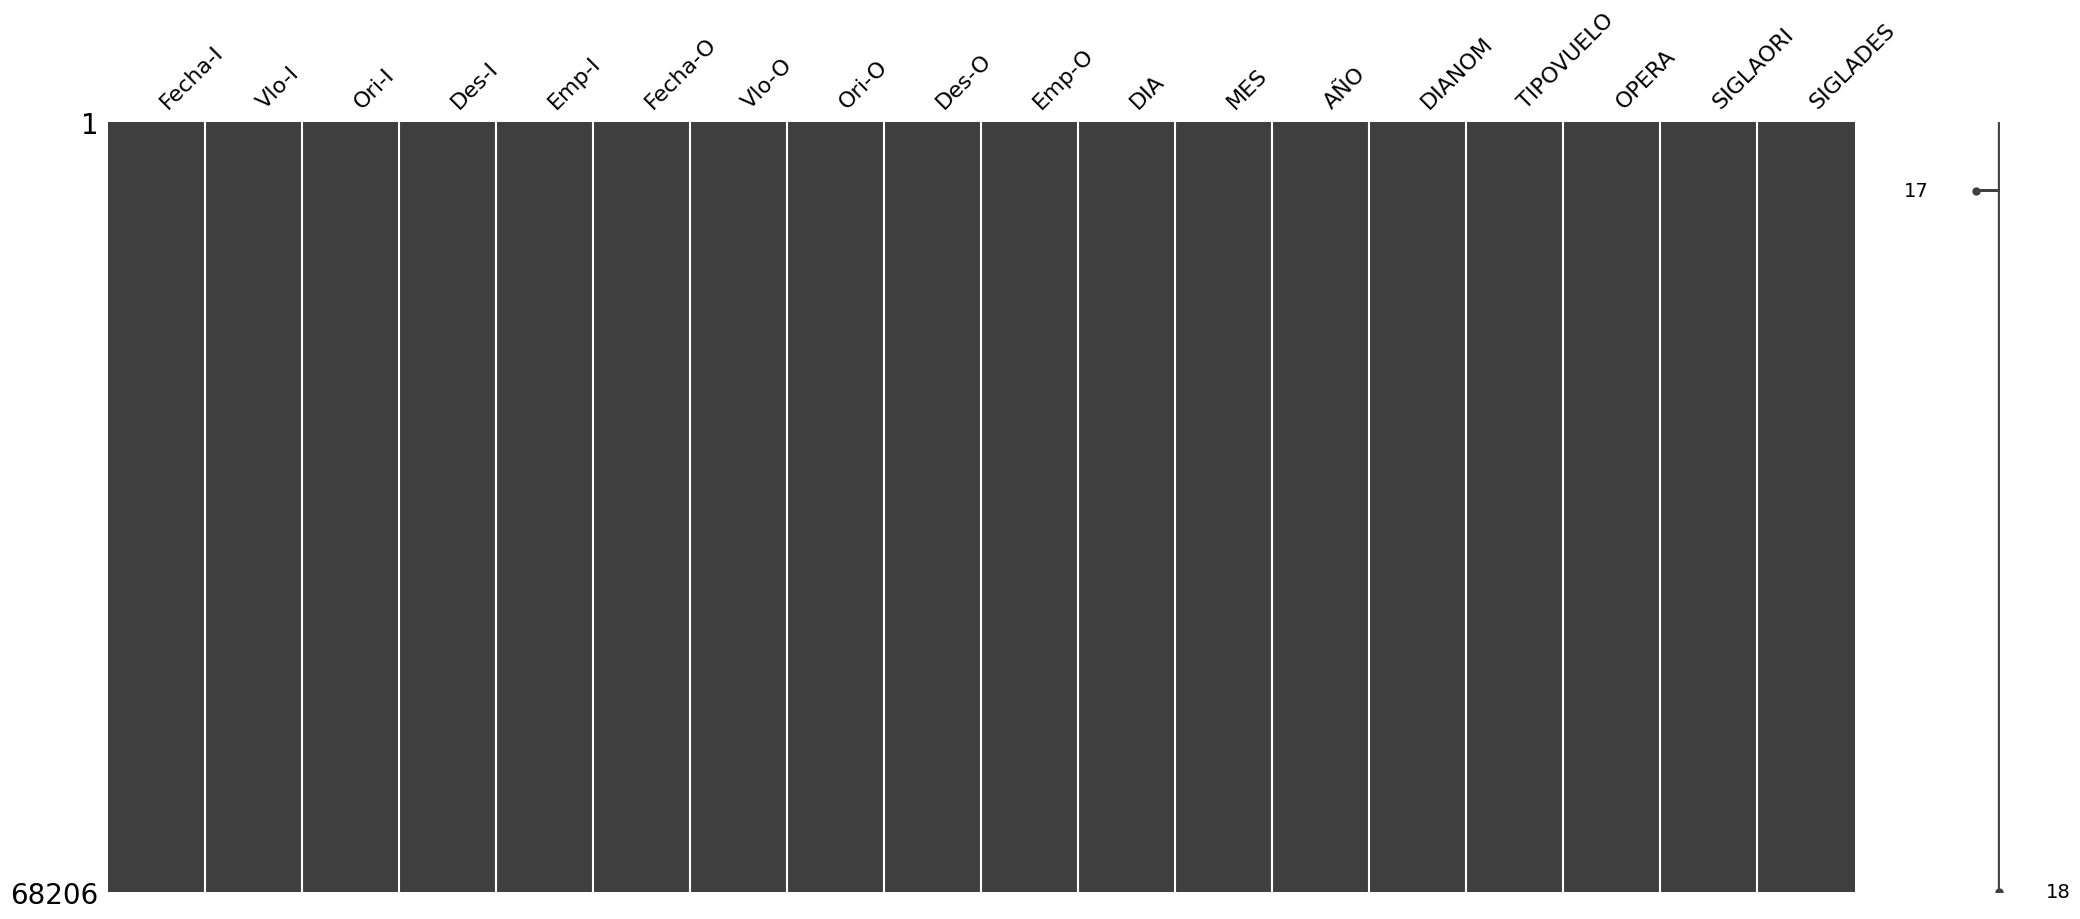

In [28]:
msno.matrix(df);

<Axes: >

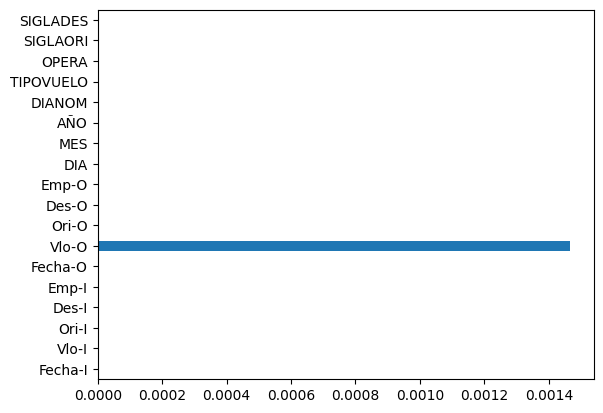

In [29]:
(df.isnull().sum()/df.shape[0]*100).plot.barh()

In [30]:
row_null_index = df['Vlo-O'][df['Vlo-O'].isnull()].index # Get index of null values
df.loc[row_null_index]

,Fecha-I,Vlo-I,Ori-I,Des-I,Emp-I,Fecha-O,Vlo-O,Ori-O,Des-O,Emp-O,DIA,MES,AÑO,DIANOM,TIPOVUELO,OPERA,SIGLAORI,SIGLADES
6068,2017-01-19 11:00:00,200,SCEL,SPJC,LAW,2017-01-19 11:03:00,NaN,SCEL,SPJC,56R,19,1,2017,Jueves,I,Latin American Wings,Santiago,Lima


Se aprecia un solo valor nulo para la columna 'Vlo-O', utilizar metodologías de imputación o buscar correlación entre columnas para determinar dato faltante.

In [31]:
df.groupby(["Ori-I",'SIGLAORI']).size()

Ori-I  SIGLAORI
SCEL   Santiago    68206
dtype: int64

In [32]:
df.groupby(["Des-I",'SIGLADES']).size()

Des-I  SIGLADES      
CYYZ   Toronto            283
EGLL   Londres            205
EGYP   Puerto Stanley       1
KATL   Atlanta            358
KDFW   Dallas             357
                         ... 
SULS   Punta del Este       6
SUMU   Montevideo        1066
YMML   Melbourne           38
YSSY   Melbourne            1
       Sydney             194
Length: 76, dtype: int64

The origin of all registered flights is Chile, so a good feature is the local weather.

Getting weather data from meteostat at airport of Santiago

In [37]:
from meteostat import Point, Daily,Hourly
from datetime import datetime
# Set time period
start = datetime(2017, 1, 1)
end = datetime(2017, 12, 31)

# Create Point for Vancouver, BC
santiago = Point(-33.40120502046634, -70.79999384307274, 520) # that cordenate correspond to the airport of Santiago

# Get data for 2017
data = Hourly(santiago, start, end)
data = data.fetch()


In [83]:
data_daily = Daily(santiago, start, end)
data_daily = data_daily.fetch()

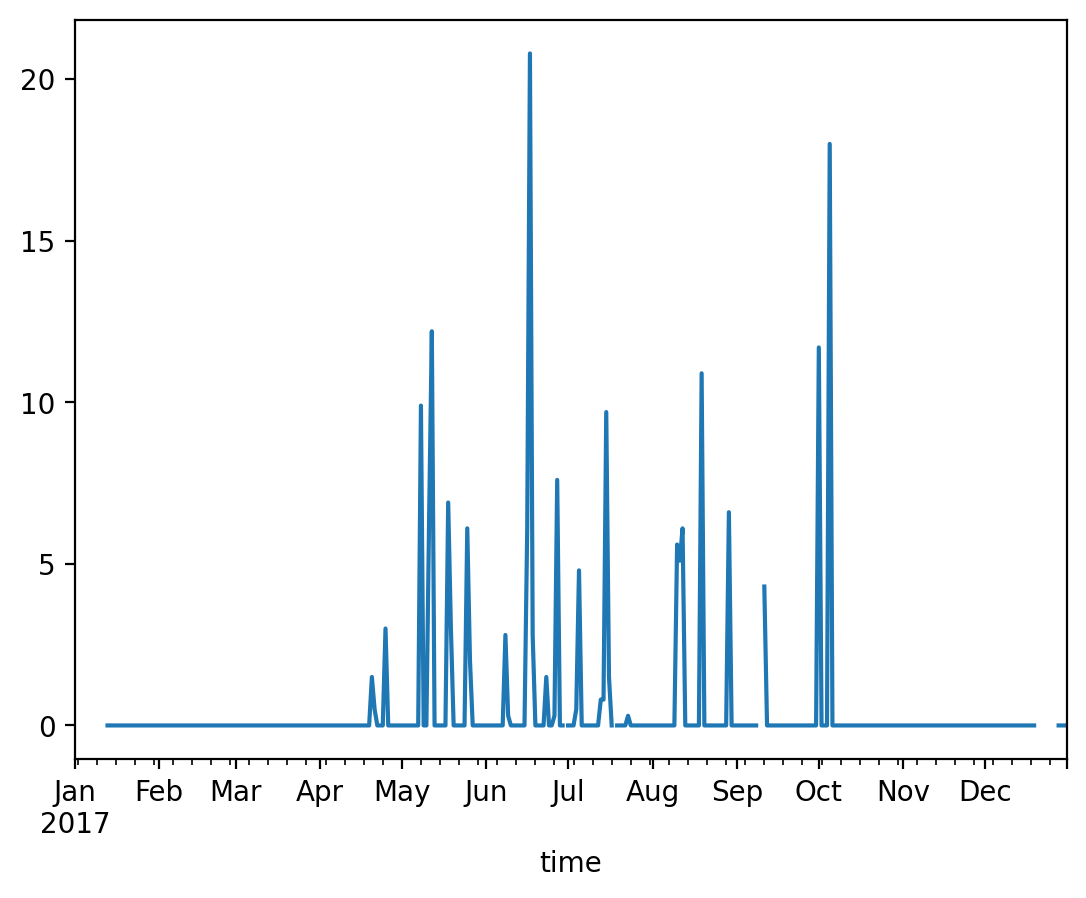

In [192]:
data_daily.prcp.plot();

In [81]:
dict_columns = {
    'time': 'Timestamp of the observation',
    'temp': 'Temperature in degrees Celsius',
    'dwpt': 'Dew point temperature in degrees Celsius',
    'rhum': 'Relative humidity as a percentage',
    'prcp': 'Precipitation in millimeters',
    'snow': 'Snowfall in centimeters',
    'wspd': 'Wind speed in kilometers per hour',
    'wdir': 'Wind direction in degrees',
    'hindex': 'Heat index in degrees Celsius',
    'coco': 'Cloud cover as a percentage',
    'vis': 'Visibility in kilometers',
    'slp': 'Sea level pressure in hPa'
}


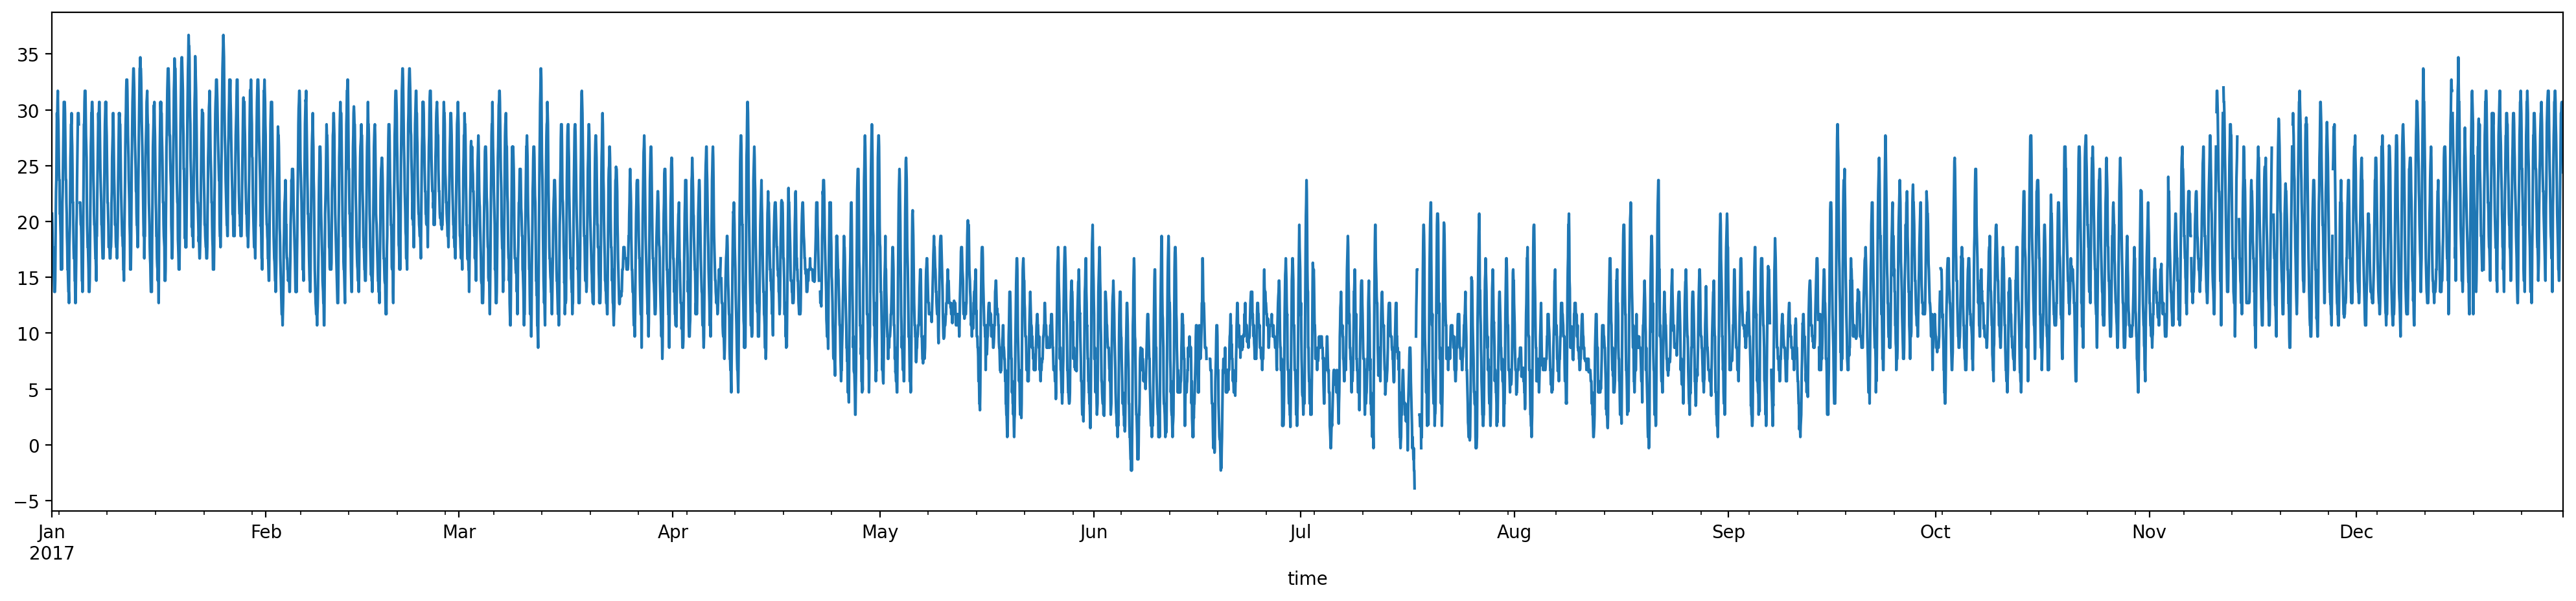

In [190]:
data.temp.plot(figsize=(25,5));

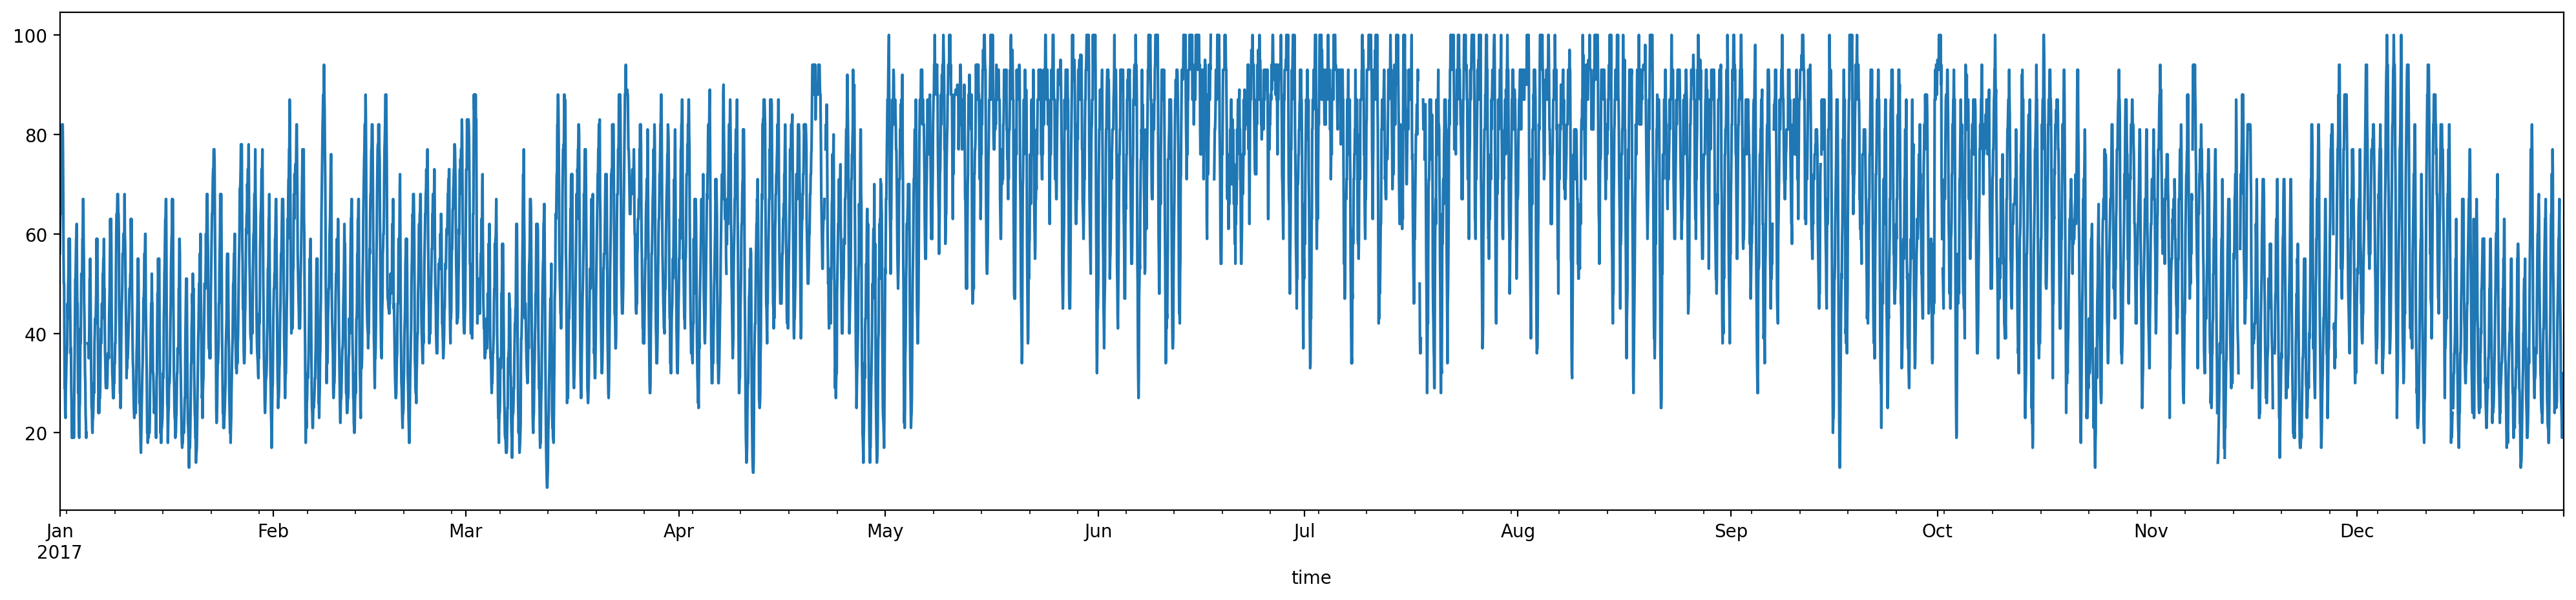

In [191]:
data.rhum.plot(figsize=(25,5));

In [15]:
data.columns

Index(['tavg', 'tmin', 'tmax', 'prcp', 'snow', 'wdir', 'wspd', 'wpgt', 'pres',
       'tsun'],
      dtype='object')

## Answers

### 1. How is the data distributed? Did you find any noteworthy insight to share? What can you conclude about this?

For this i will do a simple exploratory data analysis

### 2. Generate the following additional columns. Please export them to a CSV file named synthetic_features.csv

In [171]:
synthetic_features = pd.DataFrame()

- high_season : 1 if Date-I is between Dec-15 and Mar-3, or Jul-15 and Jul-31, or Sep-11 and Sep-30, 0 otherwise.

In [52]:
range_season1 = ((df['Fecha-I'].dt.month == 12) & (df['Fecha-I'].dt.day >= 15)) | ((df['Fecha-I'].dt.month == 1) | (df['Fecha-I'].dt.month == 2) | ((df['Fecha-I'].dt.month == 3) & (df['Fecha-I'].dt.day <= 3)))
range_season2 = ((df['Fecha-I'].dt.month == 7) & (df['Fecha-I'].dt.day >= 15) & (df['Fecha-I'].dt.day <= 31))
range_season3 = ((df['Fecha-I'].dt.month == 9) & (df['Fecha-I'].dt.day >= 11) & (df['Fecha-I'].dt.day <= 30))

In [57]:
df.loc[range_season1 | range_season2 | range_season3,'high_season'] = 1 # high season
df.high_season = df.high_season.fillna(0) # low season

In [172]:
synthetic_features['high_season'] = df.high_season

- min_diff : difference in minutes between Date-O and Date-I

In [167]:
df['min_diff'] = (df['Fecha-O']-df['Fecha-I'])/timedelta(minutes=1)


In [242]:
synthetic_features['min_diff'] = df['min_diff']

In [241]:
df[['Fecha-I','Fecha-O','min_diff']].head()

,Fecha-I,Fecha-O,min_diff
0,2017-01-01 23:30:00,2017-01-01 23:33:00,3.0
1,2017-01-02 23:30:00,2017-01-02 23:39:00,9.0
2,2017-01-03 23:30:00,2017-01-03 23:39:00,9.0
3,2017-01-04 23:30:00,2017-01-04 23:33:00,3.0
4,2017-01-05 23:30:00,2017-01-05 23:28:00,-2.0


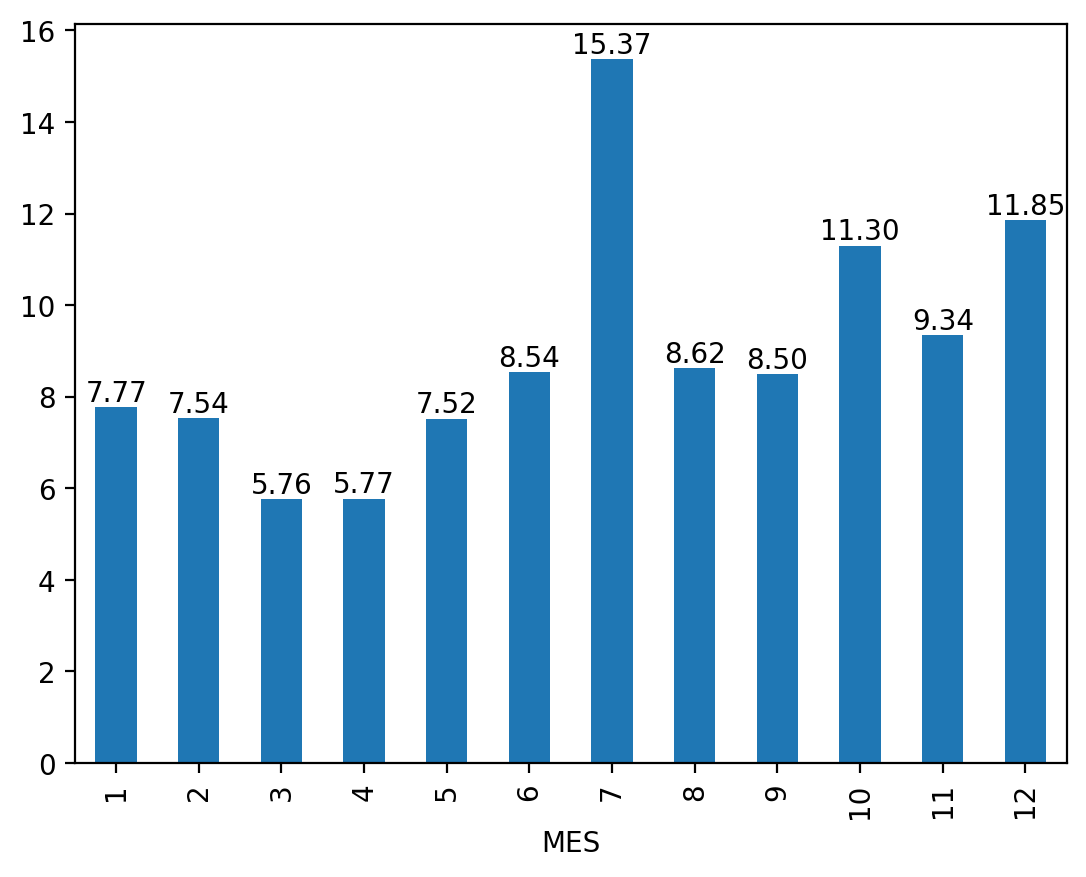

In [247]:
ax = df.groupby("MES")['min_diff'].mean().plot.bar();
ax.bar_label(ax.containers[0],fmt='%.2f');

weather data could be a good feature to predict the delay, because the delay is higher in the winter season


In [95]:
data.loc[:,'MES'] = data.index.month
data_daily.loc[:,'MES'] = data_daily.index.month

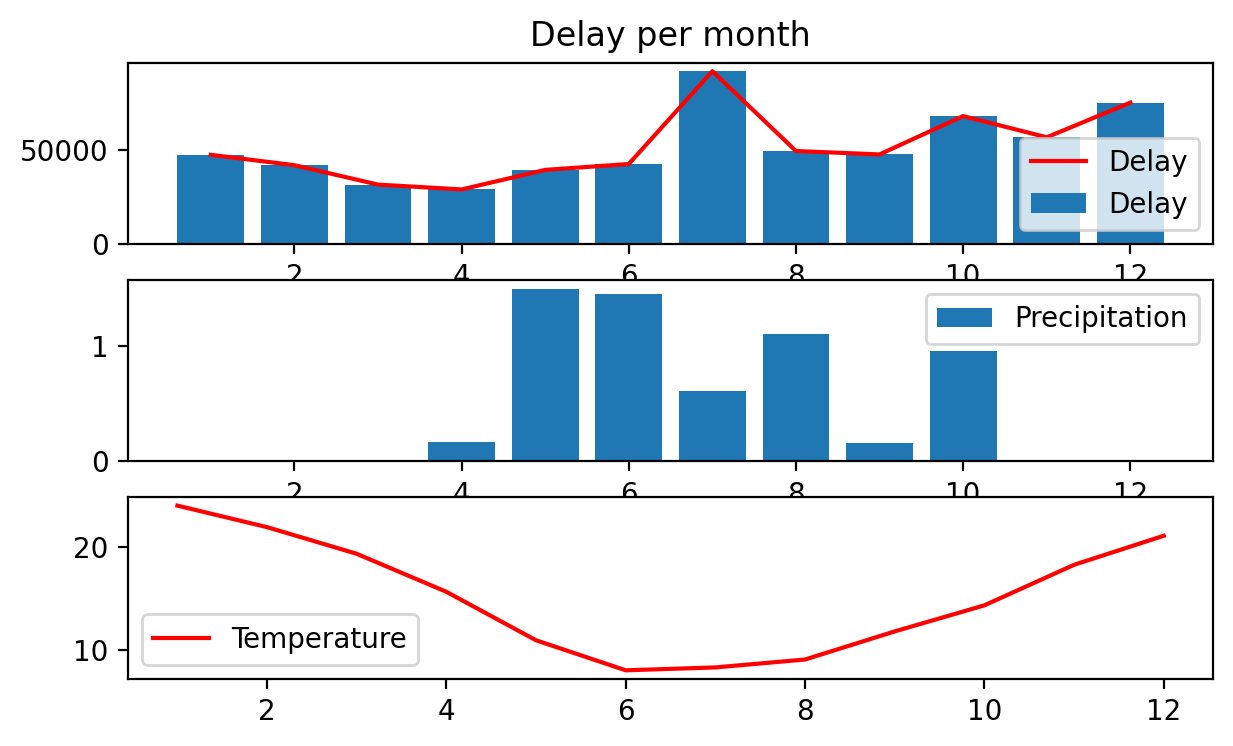

In [248]:
fig, axes = plt.subplots(3, 1, figsize=(7, 4))

axes[0].bar(df.groupby("MES")['min_diff'].sum().index, df.groupby("MES")['min_diff'].sum(), label = 'Delay')
axes[0].plot(df.groupby("MES")['min_diff'].sum().index, df.groupby("MES")['min_diff'].sum(), label = 'Delay' , c = 'r')
axes[1].bar(data_daily.groupby("MES")['prcp'].mean().index, data_daily.groupby("MES")['prcp'].mean() ,label = 'Precipitation')
axes[2].plot(data_daily.groupby("MES")['tavg'].mean().index, data_daily.groupby("MES")['tavg'].mean(), c = 'r', label = 'Temperature')

axes[0].legend()
axes[1].legend()
axes[2].legend()

axes[0].set_title('Delay per month');

- delay_15 : 1 if min_diff > 15, 0 if not.

In [182]:
synthetic_features['delay_15'] = np.where(df['min_diff'].astype(float) > 15, 1, 0)
df['delay_15'] = np.where(df['min_diff'].astype(float) > 15, 1, 0)

In [193]:
synthetic_features.delay_15.value_counts()

0    37682
1    30524
Name: delay_15, dtype: int64

- period_day : morning (between 5:00 and 11:59), afternoon (between 12:00 and 18:59) and night (between 19:00 and 4:59), based
onDate-I

In [213]:
df.loc[((df['Fecha-I'].dt.hour>=5 )& (df['Fecha-I'].dt.hour<12)),'period_day'] = 'morning'
df.loc[((df['Fecha-I'].dt.hour>=12 )& (df['Fecha-I'].dt.hour<19)),'period_day'] = 'afternoon'
df.loc[((df['Fecha-I'].dt.hour>=19 )| (df['Fecha-I'].dt.hour<5)),'period_day'] = 'night'

In [215]:
df.period_day.value_counts()

afternoon    25506
morning      25352
night        17348
Name: period_day, dtype: int64

In [216]:
synthetic_features['period_day'] = df.period_day

In [218]:
synthetic_features.to_csv('./synthetic_features.csv', index=False)